In [1]:
import os
import zarr
import timm
import random
import json
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict
import sys
import torch
from torch.cuda.amp import autocast, GradScaler

# import torchvision.transforms.functional as F
import random

warnings.filterwarnings("ignore")
sys.path.append("./src/")

from src.config import CFG
from src.dataloader import (
    read_zarr,
    read_info_json,
    scale_coordinates,
    create_dataset,
    create_segmentation_map,
    EziiDataset,
    drop_padding,
)
from src.network import Unet3D
from src.utils import save_images, PadToSize
from src.metric import (
    score,
    create_cls_pos,
    create_cls_pos_sikii,
    create_df,
    SegmentationLoss,
    DiceLoss,
)
from src.inference import inference, inference2pos, create_gt_df
from metric import visualize_epoch_results

In [2]:
train_dataset = EziiDataset(
    exp_names=CFG.train_exp_names,
    base_dir="../../inputs/train/",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.train_zarr_types,
    train=True,
    augmentation=True,
    slice=True,
    pre_read=True,
)

# train_nshuffle_dataset = EziiDataset(
#     exp_names=CFG.train_exp_names,
#     base_dir="../../inputs/train/",
#     particles_name=CFG.particles_name,
#     resolution=CFG.resolution,
#     zarr_type=CFG.train_zarr_types,
#     augmentation=False,
#     train=True,
# )

valid_dataset = EziiDataset(
    exp_names=CFG.valid_exp_names,
    base_dir="../../inputs/train/",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.valid_zarr_types,
    augmentation=False,
    train=True,
    slice=True,
    pre_read=True,
)

from tqdm import tqdm

train_loader = DataLoader(
    train_dataset,
    batch_size=CFG.batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=CFG.num_workers,
)
# train_nshuffle_loader = DataLoader(
#     train_nshuffle_dataset,
#     batch_size=1,
#     shuffle=True,
#     drop_last=True,
#     pin_memory=True,
#     num_workers=CFG.num_workers,
# )
valid_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    pin_memory=True,
    num_workers=CFG.num_workers,
)

for data in tqdm(train_loader):
    normalized_tomogram = data["normalized_tomogram"]
    segmentation_map = data["segmentation_map"]
    break

normalized_tomogram.shape

  0%|          | 0/181 [00:08<?, ?it/s]


torch.Size([2, 16, 630, 630])

In [3]:
# from tqdm import tqdm

# train_loader = DataLoader(
#     train_dataset,
#     batch_size=CFG.batch_size,
#     shuffle=True,
#     drop_last=True,
#     pin_memory=True,
#     num_workers=CFG.num_workers,
# )
# # train_nshuffle_loader = DataLoader(
# #     train_nshuffle_dataset,
# #     batch_size=1,
# #     shuffle=True,
# #     drop_last=True,
# #     pin_memory=True,
# #     num_workers=CFG.num_workers,
# # )
# valid_loader = DataLoader(
#     valid_dataset,
#     batch_size=1,
#     shuffle=False,
#     pin_memory=True,
#     num_workers=CFG.num_workers,
# )

# for data in tqdm(train_loader):
#     normalized_tomogram = data["normalized_tomogram"]
#     segmentation_map = data["segmentation_map"]
#     break

# normalized_tomogram.shape

In [4]:
encoder = timm.create_model(
    model_name=CFG.model_name,
    pretrained=True,
    in_chans=3,
    num_classes=0,
    global_pool="",
    features_only=True,
)
model = Unet3D(encoder=encoder).to("cuda")
# model.load_state_dict(torch.load("./pretrained_model.pth"))
# model.load_state_dict(torch.load("./best_model.pth"))

In [5]:
# # "encoder"と名のつくパラメータは学習しない
# for layer, param in model.named_parameters():
#     if "encoder" in layer:
#         param.requires_grad = False

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# サンプルデータ
num_classes = len(CFG.particles_name)  # クラス数
colors = plt.cm.tab10(
    np.arange(len(CFG.particles_name))
)  # "tab10" カラーマップから色を取得

# ListedColormap を作成
class_colormap = ListedColormap(colors)


# カラーバー付きプロット
def plot_with_colormap(data, title, original_tomogram):
    masked_data = np.ma.masked_where(data <= 0, data)  # クラス0をマスク
    plt.imshow(original_tomogram, cmap="gray")
    im = plt.imshow(masked_data, cmap=class_colormap)
    plt.title(title)
    plt.axis("off")
    return im

In [7]:
import torch
import random
import torchvision.transforms.functional as TF


# 回転
# 3Dテンソルの各軸に対して指定した角度で回転する関数
def rotate_3d(tomogram, segmentation_map, angle):
    """Rotates the 3D tensors tomogram and segmentation_map around the Z-axis."""
    rotated_tomogram = TF.rotate(tomogram, angle, expand=False)
    rotated_segmentation_map = TF.rotate(segmentation_map, angle, expand=False)
    return rotated_tomogram, rotated_segmentation_map


# 平行移動
# 指定された範囲でランダムに平行移動
def translate_3d(tomogram, segmentation_map, max_shift):
    """Translates the 3D tensors by a random shift within max_shift."""
    shift_x = random.randint(-max_shift, max_shift)
    shift_y = random.randint(-max_shift, max_shift)
    translated_tomogram = TF.affine(
        tomogram, angle=0, translate=(shift_x, shift_y), scale=1, shear=0
    )
    translated_segmentation_map = TF.affine(
        segmentation_map, angle=0, translate=(shift_x, shift_y), scale=1, shear=0
    )
    return translated_tomogram, translated_segmentation_map


# フリップ
# 縦横（上下左右）ランダムフリップ
def flip_3d(tomogram, segmentation_map):
    """Randomly flips the 3D tensors along height or width."""
    if random.random() > 0.5:  # Horizontal flip
        tomogram = torch.flip(tomogram, dims=[-1])
        segmentation_map = torch.flip(segmentation_map, dims=[-1])
    if random.random() > 0.5:  # Vertical flip
        tomogram = torch.flip(tomogram, dims=[-2])
        segmentation_map = torch.flip(segmentation_map, dims=[-2])
    return tomogram, segmentation_map


# クロッピング
# 入力テンソルを中心またはランダムクロップで切り取る
def crop_3d(tomogram, segmentation_map, crop_size):
    """Crops the 3D tensors to the specified crop_size."""
    _, depth, height, width = tomogram.size()
    crop_d, crop_h, crop_w = crop_size

    if crop_h > height or crop_w > width:
        raise ValueError("Crop size cannot be larger than the original size.")

    start_h = random.randint(0, height - crop_h)  # Random starting position for height
    start_w = random.randint(0, width - crop_w)  # Random starting position for width

    cropped_tomogram = tomogram[
        :, :, start_h : start_h + crop_h, start_w : start_w + crop_w
    ]
    cropped_segmentation_map = segmentation_map[
        :, :, start_h : start_h + crop_h, start_w : start_w + crop_w
    ]

    return cropped_tomogram, cropped_segmentation_map


# Mixup
# 2つのサンプルを線形補間して混合
def mixup(tomogram, segmentation_map, alpha=0.4):
    """Applies mixup augmentation to the batch."""
    lam = random.betavariate(alpha, alpha)
    batch_size = tomogram.size(0)
    index = torch.randperm(batch_size)

    mixed_tomogram = lam * tomogram + (1 - lam) * tomogram[index, :]
    mixed_segmentation_map = (
        lam * segmentation_map + (1 - lam) * segmentation_map[index, :]
    )

    return mixed_tomogram, mixed_segmentation_map


# Cutmix
# ランダム領域を切り取って別のサンプルに貼り付け
def cutmix(tomogram, segmentation_map, alpha=1.0):
    """Applies cutmix augmentation to the batch."""
    lam = random.betavariate(alpha, alpha)
    batch_size, depth, height, width = tomogram.size()
    index = torch.randperm(batch_size)

    cx = random.randint(0, width)
    cy = random.randint(0, height)
    cw = int(width * (1 - lam))
    ch = int(height * (1 - lam))

    x1 = max(cx - cw // 2, 0)
    x2 = min(cx + cw // 2, width)
    y1 = max(cy - ch // 2, 0)
    y2 = min(cy + ch // 2, height)

    tomogram[:, :, y1:y2, x1:x2] = tomogram[index, :, y1:y2, x1:x2]
    segmentation_map[:, :, y1:y2, x1:x2] = segmentation_map[index, :, y1:y2, x1:x2]

    return tomogram, segmentation_map


# データ拡張の組み合わせ適用
def augment_data(
    tomogram,
    segmentation_map,
    crop_size=(16, 256, 256),
    max_shift=10,
    rotation_angle=30,
    p=0.5,
    mixup_alpha=0.4,
    cutmix_alpha=1.0,
):
    """Applies a combination of rotation, translation, flipping, cropping, mixup, and cutmix to the inputs with probabilities."""
    if random.random() < p:
        tomogram, segmentation_map = rotate_3d(
            tomogram,
            segmentation_map,
            angle=random.uniform(-rotation_angle, rotation_angle),
        )
    if random.random() < p:
        tomogram, segmentation_map = translate_3d(
            tomogram, segmentation_map, max_shift=max_shift
        )
    if random.random() < p:
        tomogram, segmentation_map = flip_3d(tomogram, segmentation_map)
    if random.random() < p:
        tomogram, segmentation_map = crop_3d(
            tomogram, segmentation_map, crop_size=crop_size
        )
    if random.random() < p:
        tomogram, segmentation_map = mixup(
            tomogram, segmentation_map, alpha=mixup_alpha
        )
    # if random.random() < p:
    #     tomogram, segmentation_map = cutmix(
    #         tomogram, segmentation_map, alpha=cutmix_alpha
    #     )
    return tomogram, segmentation_map


# 使用例
# バッチサイズ6, 深さ16, 高さ320, 幅320のランダムテンソル
tomogram = torch.rand((6, 16, 320, 320))
segmentation_map = torch.randint(0, 2, (6, 16, 320, 320))  # ラベルは0または1

# データ拡張の適用
aug_tomogram, aug_segmentation_map = augment_data(tomogram, segmentation_map, p=0.7)
print("Original shape:", tomogram.shape)
print("Augmented shape:", aug_tomogram.shape)

Original shape: torch.Size([6, 16, 320, 320])
Augmented shape: torch.Size([6, 16, 256, 256])


In [8]:
from transformers import get_cosine_schedule_with_warmup

optimizer = torch.optim.Adam(
    model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay
)
criterion = nn.CrossEntropyLoss(
    #  weight=torch.tensor([2.0, 32, 32, 32, 32, 32, 32]).to("cuda")
)
# criterion = DiceLoss()
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=10,
    num_training_steps=CFG.epochs * len(train_loader),
    # * batch_size,
)
scaler = GradScaler()
seg_loss = SegmentationLoss(criterion)
padf = PadToSize(CFG.resolution)

In [9]:
# b, c, d, h, w = CFG.batch_size, 1, 96, 320, 320

In [10]:
def preprocess_tensor(tensor):
    batch_size, depth, height, width = tensor.shape
    tensor = tensor.unsqueeze(2)  # (b, d, h, w) -> (b, d, 1, h, w)
    return tensor

In [11]:
padf = PadToSize(CFG.resolution)
padf(normalized_tomogram).shape

torch.Size([2, 16, 640, 640])

In [12]:
best_model = None
best_constant = 0
best_score = -100

grand_train_loss = []
grand_valid_loss = []
grand_train_score = []
grand_valid_score = []

for epoch in range(CFG.epochs):
    model.train()
    train_loss = []
    valid_loss = []
    with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{CFG.epochs} [Training]") as tq:
        for data in tq:
            normalized_tomogram = data["normalized_tomogram"]
            segmentation_map = data["segmentation_map"]

            normalized_tomogram = padf(normalized_tomogram)
            segmentation_map = padf(segmentation_map)

            # データ拡張
            normalized_tomogram, segmentation_map = augment_data(
                normalized_tomogram, segmentation_map, p=CFG.augmentation_prob
            )
            normalized_tomogram = normalized_tomogram.cuda()
            segmentation_map = segmentation_map.long().cuda()

            optimizer.zero_grad()

            with autocast():
                pred = model(preprocess_tensor(normalized_tomogram))
                loss = seg_loss(pred, segmentation_map)
            # loss.backward()
            # optimizer.step()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            train_loss.append(loss.item())

            # 確率予測
            prob_pred = torch.softmax(pred, dim=1)
            tq.set_postfix({"loss": f"{np.mean(train_loss):.4f}"})

    with tqdm(valid_loader, desc=f"Epoch {epoch + 1}/{CFG.epochs} [Validation]") as tq:
        for data in tq:
            normalized_tomogram = data["normalized_tomogram"].cuda()
            segmentation_map = data["segmentation_map"].long().cuda()

            normalized_tomogram = padf(normalized_tomogram)
            segmentation_map = padf(segmentation_map)

            with autocast():
                pred = model(preprocess_tensor(normalized_tomogram))
                loss = seg_loss(pred, segmentation_map)
            valid_loss.append(loss.item())

            # 確率予測
            prob_pred = torch.softmax(pred, dim=1)
            tq.set_postfix({"loss": f"{np.mean(valid_loss):.4f}"})

    # # ############### validation ################
    train_nshuffle_original_tomogram = defaultdict(list)
    train_nshuffle_pred_tomogram = defaultdict(list)
    train_nshuffle_gt_tomogram = defaultdict(list)

    valid_original_tomogram = defaultdict(list)
    valid_pred_tomogram = defaultdict(list)
    valid_gt_tomogram = defaultdict(list)

    train_mean_scores = []
    valid_mean_scores = []

    # モデルの保存
    torch.save(model.state_dict(), "./pretrained_model.pth")

    # ############### validation ################
    train_nshuffle_original_tomogram = defaultdict(list)
    train_nshuffle_pred_tomogram = defaultdict(list)
    train_nshuffle_gt_tomogram = defaultdict(list)

    valid_original_tomogram = defaultdict(list)
    valid_pred_tomogram = defaultdict(list)
    valid_gt_tomogram = defaultdict(list)

    train_mean_scores = []
    valid_mean_scores = []

    train_inferenced_array = {}
    train_pred_array = []
    train_gt_array = []
    valid_inferenced_array = {}
    valid_gt_array = []

    # for exp_name in tqdm(CFG.train_exp_names):
    for exp_name in [CFG.valid_exp_name]:  # 5つのデータで試す
        # inferenced_array = inference(model, exp_name, train=False)
        inferenced_array, n_tomogram, segmentation_map = inference(
            model, exp_name, train=False
        )
        valid_inferenced_array[exp_name] = inferenced_array
        base_dir = "../../inputs/train/overlay/ExperimentRuns/"
        gt_df = create_gt_df(base_dir, [exp_name])
        valid_gt_array.append(gt_df)

    valid_gt_array = pd.concat(valid_gt_array)

    b_constant = 0
    b_score = -100
    for constant in tqdm(np.linspace(0.1, 0.9, 15)):
        valid_pred_array = []
        sikii = {
            "apo-ferritin": constant,
            "beta-amylase": constant,
            "beta-galactosidase": constant,
            "ribosome": constant,
            "thyroglobulin": constant,
            "virus-like-particle": constant,
        }
        for exp_name in [CFG.valid_exp_name]:  # 5つのデータで試す
            pred_df = inference2pos(
                pred_segmask=valid_inferenced_array[exp_name],
                exp_name=exp_name,
                sikii_dict=sikii,
            )
            valid_pred_array.append(pred_df)

        valid_pred_array = pd.concat(valid_pred_array)

        if len(valid_pred_array) != 0:
            score_ = score(
                valid_pred_array,
                valid_gt_array,
                row_id_column_name="index",
                distance_multiplier=1.0,
                beta=4,
            )
            if score_ > b_score:
                b_score = score_
                b_constant = constant

        import gc
        import torch.cuda as cuda

        gc.collect()
        cuda.empty_cache()

    print("constant", b_constant, "score", b_score)

    if b_score > best_score:
        best_constant = b_constant
        best_score = b_score
        # best_score = np.mean(valid_mean_scores)
        best_model = model.state_dict()
        torch.save(best_model, f"./best_model.pth")

    print(
        f"train-epoch-loss:{np.mean(train_loss):.4f}",
        f"valid-epoch-loss:{np.mean(valid_loss):.4f}",
        # f"train-beta4-score:{np.mean(train_mean_scores):.4f}",
        f"valid-beta4-score:{b_score:.4f}",
    )

    grand_train_loss.append(np.mean(train_loss))
    grand_valid_loss.append(np.mean(valid_loss))
    # grand_train_score.append(np.mean(train_mean_scores))
    grand_valid_score.append(b_score)

100%|██████████| 15/15 [00:33<00:00,  2.26s/it]


constant 0.9 score 0.06340532570040766
train-epoch-loss:1.5279 valid-epoch-loss:0.8161 valid-beta4-score:0.0634


100%|██████████| 15/15 [00:30<00:00,  2.05s/it]


constant 0.1 score 0.03831854079635923
train-epoch-loss:0.3970 valid-epoch-loss:0.1368 valid-beta4-score:0.0383


100%|██████████| 15/15 [00:30<00:00,  2.04s/it]


constant 0.2142857142857143 score 0.0445128994994224
train-epoch-loss:0.1149 valid-epoch-loss:0.0631 valid-beta4-score:0.0445


100%|██████████| 15/15 [00:30<00:00,  2.04s/it]


constant 0.44285714285714284 score 0.07241558441558442
train-epoch-loss:0.0689 valid-epoch-loss:0.0528 valid-beta4-score:0.0724


100%|██████████| 15/15 [00:30<00:00,  2.06s/it]


constant 0.44285714285714284 score 0.05380882042625027
train-epoch-loss:0.0602 valid-epoch-loss:0.0278 valid-beta4-score:0.0538


100%|██████████| 15/15 [00:30<00:00,  2.03s/it]


constant 0.44285714285714284 score 0.05842593653339443
train-epoch-loss:0.0566 valid-epoch-loss:0.0171 valid-beta4-score:0.0584


100%|██████████| 15/15 [00:30<00:00,  2.02s/it]


constant 0.3285714285714286 score 0.06837479517354388
train-epoch-loss:0.0528 valid-epoch-loss:0.0354 valid-beta4-score:0.0684


100%|██████████| 15/15 [00:30<00:00,  2.04s/it]


constant 0.5571428571428572 score 0.0709812108559499
train-epoch-loss:0.0505 valid-epoch-loss:0.0177 valid-beta4-score:0.0710


100%|██████████| 15/15 [00:30<00:00,  2.03s/it]


constant 0.3285714285714286 score 0.10793650793650791
train-epoch-loss:0.0499 valid-epoch-loss:0.0308 valid-beta4-score:0.1079


100%|██████████| 15/15 [00:30<00:00,  2.04s/it]


constant 0.9 score 0.07603262299394896
train-epoch-loss:0.0537 valid-epoch-loss:0.0331 valid-beta4-score:0.0760


100%|██████████| 15/15 [00:30<00:00,  2.03s/it]


constant 0.2142857142857143 score 0.10261569416498995
train-epoch-loss:0.0484 valid-epoch-loss:0.0273 valid-beta4-score:0.1026


100%|██████████| 15/15 [00:30<00:00,  2.04s/it]


constant 0.2142857142857143 score 0.0851726472579553
train-epoch-loss:0.0471 valid-epoch-loss:0.0310 valid-beta4-score:0.0852


100%|██████████| 15/15 [00:30<00:00,  2.06s/it]


constant 0.15714285714285714 score 0.1319322583748607
train-epoch-loss:0.0465 valid-epoch-loss:0.0260 valid-beta4-score:0.1319


100%|██████████| 15/15 [00:30<00:00,  2.04s/it]


constant 0.6714285714285715 score 0.13039309683604985
train-epoch-loss:0.0460 valid-epoch-loss:0.0039 valid-beta4-score:0.1304


100%|██████████| 15/15 [00:31<00:00,  2.10s/it]


constant 0.3857142857142858 score 0.16372765107721904
train-epoch-loss:0.0485 valid-epoch-loss:0.0282 valid-beta4-score:0.1637


100%|██████████| 15/15 [00:31<00:00,  2.09s/it]


constant 0.44285714285714284 score 0.18224138572544796
train-epoch-loss:0.0443 valid-epoch-loss:0.0079 valid-beta4-score:0.1822


100%|██████████| 15/15 [00:30<00:00,  2.06s/it]


constant 0.3285714285714286 score 0.1614954258759193
train-epoch-loss:0.0446 valid-epoch-loss:0.0076 valid-beta4-score:0.1615


100%|██████████| 15/15 [00:30<00:00,  2.02s/it]


constant 0.1 score 0.31063302849445495
train-epoch-loss:0.0462 valid-epoch-loss:0.0221 valid-beta4-score:0.3106


100%|██████████| 15/15 [00:31<00:00,  2.11s/it]


constant 0.44285714285714284 score 0.1643021004022047
train-epoch-loss:0.0453 valid-epoch-loss:0.0142 valid-beta4-score:0.1643


100%|██████████| 15/15 [00:31<00:00,  2.09s/it]


constant 0.27142857142857146 score 0.18080060905228518
train-epoch-loss:0.0479 valid-epoch-loss:0.0089 valid-beta4-score:0.1808


100%|██████████| 15/15 [00:31<00:00,  2.10s/it]


constant 0.27142857142857146 score 0.15320595132419454
train-epoch-loss:0.0439 valid-epoch-loss:0.0238 valid-beta4-score:0.1532


100%|██████████| 15/15 [00:31<00:00,  2.08s/it]


constant 0.15714285714285714 score 0.2208276005796271
train-epoch-loss:0.0452 valid-epoch-loss:0.0064 valid-beta4-score:0.2208


100%|██████████| 15/15 [00:31<00:00,  2.08s/it]


constant 0.1 score 0.13031784024831403
train-epoch-loss:0.0435 valid-epoch-loss:0.0038 valid-beta4-score:0.1303


100%|██████████| 15/15 [00:31<00:00,  2.09s/it]


constant 0.15714285714285714 score 0.24551327777516932
train-epoch-loss:0.0412 valid-epoch-loss:0.0251 valid-beta4-score:0.2455


100%|██████████| 15/15 [00:31<00:00,  2.13s/it]


constant 0.27142857142857146 score 0.24969303211268962
train-epoch-loss:0.0438 valid-epoch-loss:0.0276 valid-beta4-score:0.2497


100%|██████████| 15/15 [00:31<00:00,  2.10s/it]


constant 0.27142857142857146 score 0.20739225992111363
train-epoch-loss:0.0459 valid-epoch-loss:0.0096 valid-beta4-score:0.2074


100%|██████████| 15/15 [00:31<00:00,  2.11s/it]


constant 0.27142857142857146 score 0.22863213954205147
train-epoch-loss:0.0420 valid-epoch-loss:0.0139 valid-beta4-score:0.2286


100%|██████████| 15/15 [00:31<00:00,  2.08s/it]


constant 0.3285714285714286 score 0.42435091099086003
train-epoch-loss:0.0468 valid-epoch-loss:0.0199 valid-beta4-score:0.4244


100%|██████████| 15/15 [00:31<00:00,  2.11s/it]


constant 0.3857142857142858 score 0.29773320021979216
train-epoch-loss:0.0443 valid-epoch-loss:0.0036 valid-beta4-score:0.2977


100%|██████████| 15/15 [00:31<00:00,  2.09s/it]


constant 0.3857142857142858 score 0.32548814189982483
train-epoch-loss:0.0421 valid-epoch-loss:0.0022 valid-beta4-score:0.3255


100%|██████████| 15/15 [00:31<00:00,  2.09s/it]


constant 0.1 score 0.1641116686028035
train-epoch-loss:0.0425 valid-epoch-loss:0.0300 valid-beta4-score:0.1641


100%|██████████| 15/15 [00:31<00:00,  2.12s/it]


constant 0.3285714285714286 score 0.22582699085845293
train-epoch-loss:0.0398 valid-epoch-loss:0.0086 valid-beta4-score:0.2258


100%|██████████| 15/15 [00:32<00:00,  2.17s/it]


constant 0.5 score 0.26462797221770296
train-epoch-loss:0.0431 valid-epoch-loss:0.0023 valid-beta4-score:0.2646


100%|██████████| 15/15 [00:31<00:00,  2.12s/it]


constant 0.5 score 0.3204722785305309
train-epoch-loss:0.0417 valid-epoch-loss:0.0045 valid-beta4-score:0.3205


100%|██████████| 15/15 [00:32<00:00,  2.15s/it]


constant 0.6142857142857143 score 0.305835978411578
train-epoch-loss:0.0412 valid-epoch-loss:0.0043 valid-beta4-score:0.3058


100%|██████████| 15/15 [00:32<00:00,  2.15s/it]


constant 0.44285714285714284 score 0.27509881976465317
train-epoch-loss:0.0407 valid-epoch-loss:0.0144 valid-beta4-score:0.2751


100%|██████████| 15/15 [00:31<00:00,  2.11s/it]


constant 0.44285714285714284 score 0.2943145553108216
train-epoch-loss:0.0441 valid-epoch-loss:0.0225 valid-beta4-score:0.2943


100%|██████████| 15/15 [00:31<00:00,  2.13s/it]


constant 0.2142857142857143 score 0.4357485281732859
train-epoch-loss:0.0407 valid-epoch-loss:0.0070 valid-beta4-score:0.4357


100%|██████████| 15/15 [00:31<00:00,  2.10s/it]


constant 0.2142857142857143 score 0.3679388222980258
train-epoch-loss:0.0427 valid-epoch-loss:0.0170 valid-beta4-score:0.3679


100%|██████████| 15/15 [00:31<00:00,  2.12s/it]


constant 0.5571428571428572 score 0.32772919641446974
train-epoch-loss:0.0411 valid-epoch-loss:0.0218 valid-beta4-score:0.3277


100%|██████████| 15/15 [00:31<00:00,  2.12s/it]


constant 0.44285714285714284 score 0.29410364851346255
train-epoch-loss:0.0396 valid-epoch-loss:0.0072 valid-beta4-score:0.2941


100%|██████████| 15/15 [00:32<00:00,  2.18s/it]


constant 0.5571428571428572 score 0.29251490820949994
train-epoch-loss:0.0405 valid-epoch-loss:0.0185 valid-beta4-score:0.2925


100%|██████████| 15/15 [00:31<00:00,  2.10s/it]


constant 0.2142857142857143 score 0.3647473796614258
train-epoch-loss:0.0381 valid-epoch-loss:0.0056 valid-beta4-score:0.3647


100%|██████████| 15/15 [00:32<00:00,  2.18s/it]


constant 0.27142857142857146 score 0.3259070521971966
train-epoch-loss:0.0405 valid-epoch-loss:0.0051 valid-beta4-score:0.3259


100%|██████████| 15/15 [00:32<00:00,  2.15s/it]


constant 0.27142857142857146 score 0.3487653224162931
train-epoch-loss:0.0415 valid-epoch-loss:0.0164 valid-beta4-score:0.3488


100%|██████████| 15/15 [00:32<00:00,  2.14s/it]


constant 0.27142857142857146 score 0.32715869723070956
train-epoch-loss:0.0392 valid-epoch-loss:0.0193 valid-beta4-score:0.3272


100%|██████████| 15/15 [00:31<00:00,  2.12s/it]


constant 0.27142857142857146 score 0.37228224886336775
train-epoch-loss:0.0408 valid-epoch-loss:0.0183 valid-beta4-score:0.3723


100%|██████████| 15/15 [00:32<00:00,  2.14s/it]


constant 0.3285714285714286 score 0.3700362683636808
train-epoch-loss:0.0371 valid-epoch-loss:0.0214 valid-beta4-score:0.3700


100%|██████████| 15/15 [00:32<00:00,  2.15s/it]


constant 0.3285714285714286 score 0.4354302105577637
train-epoch-loss:0.0379 valid-epoch-loss:0.0007 valid-beta4-score:0.4354


100%|██████████| 15/15 [00:32<00:00,  2.13s/it]


constant 0.3285714285714286 score 0.4023020486935698
train-epoch-loss:0.0391 valid-epoch-loss:0.0171 valid-beta4-score:0.4023


100%|██████████| 15/15 [00:32<00:00,  2.14s/it]


constant 0.3285714285714286 score 0.465362924863246
train-epoch-loss:0.0379 valid-epoch-loss:0.0189 valid-beta4-score:0.4654


100%|██████████| 15/15 [00:31<00:00,  2.12s/it]


constant 0.27142857142857146 score 0.4095460108382279
train-epoch-loss:0.0393 valid-epoch-loss:0.0100 valid-beta4-score:0.4095


100%|██████████| 15/15 [00:32<00:00,  2.16s/it]


constant 0.3857142857142858 score 0.4783379076229829
train-epoch-loss:0.0395 valid-epoch-loss:0.0050 valid-beta4-score:0.4783


100%|██████████| 15/15 [00:32<00:00,  2.14s/it]


constant 0.3285714285714286 score 0.4075222182110682
train-epoch-loss:0.0373 valid-epoch-loss:0.0201 valid-beta4-score:0.4075


100%|██████████| 15/15 [00:32<00:00,  2.16s/it]


constant 0.3285714285714286 score 0.4190516790120528
train-epoch-loss:0.0355 valid-epoch-loss:0.0125 valid-beta4-score:0.4191


100%|██████████| 15/15 [00:32<00:00,  2.14s/it]


constant 0.3285714285714286 score 0.40718326969985885
train-epoch-loss:0.0419 valid-epoch-loss:0.0076 valid-beta4-score:0.4072


100%|██████████| 15/15 [00:32<00:00,  2.15s/it]


constant 0.3857142857142858 score 0.3982783909506896
train-epoch-loss:0.0375 valid-epoch-loss:0.0009 valid-beta4-score:0.3983


100%|██████████| 15/15 [00:32<00:00,  2.15s/it]


constant 0.3285714285714286 score 0.3465568257856449
train-epoch-loss:0.0407 valid-epoch-loss:0.0014 valid-beta4-score:0.3466


100%|██████████| 15/15 [00:32<00:00,  2.14s/it]


constant 0.3857142857142858 score 0.4151171691803608
train-epoch-loss:0.0378 valid-epoch-loss:0.0013 valid-beta4-score:0.4151


100%|██████████| 15/15 [00:32<00:00,  2.16s/it]


constant 0.3857142857142858 score 0.4292439783964919
train-epoch-loss:0.0368 valid-epoch-loss:0.0019 valid-beta4-score:0.4292


100%|██████████| 15/15 [00:32<00:00,  2.18s/it]


constant 0.44285714285714284 score 0.47974463470989065
train-epoch-loss:0.0386 valid-epoch-loss:0.0160 valid-beta4-score:0.4797


100%|██████████| 15/15 [00:32<00:00,  2.15s/it]


constant 0.44285714285714284 score 0.541396896480501
train-epoch-loss:0.0373 valid-epoch-loss:0.0182 valid-beta4-score:0.5414


100%|██████████| 15/15 [00:32<00:00,  2.15s/it]


constant 0.44285714285714284 score 0.47344302360265184
train-epoch-loss:0.0395 valid-epoch-loss:0.0160 valid-beta4-score:0.4734


100%|██████████| 15/15 [00:32<00:00,  2.16s/it]


constant 0.44285714285714284 score 0.4086965068592442
train-epoch-loss:0.0389 valid-epoch-loss:0.0143 valid-beta4-score:0.4087


100%|██████████| 15/15 [00:32<00:00,  2.17s/it]


constant 0.5 score 0.48876942503708076
train-epoch-loss:0.0366 valid-epoch-loss:0.0186 valid-beta4-score:0.4888


100%|██████████| 15/15 [00:32<00:00,  2.16s/it]


constant 0.44285714285714284 score 0.4765662211824412
train-epoch-loss:0.0361 valid-epoch-loss:0.0190 valid-beta4-score:0.4766


100%|██████████| 15/15 [00:32<00:00,  2.18s/it]


constant 0.44285714285714284 score 0.37798882670252265
train-epoch-loss:0.0377 valid-epoch-loss:0.0190 valid-beta4-score:0.3780


100%|██████████| 15/15 [00:32<00:00,  2.15s/it]


constant 0.44285714285714284 score 0.40772026281623724
train-epoch-loss:0.0362 valid-epoch-loss:0.0190 valid-beta4-score:0.4077


100%|██████████| 15/15 [00:33<00:00,  2.24s/it]


constant 0.5 score 0.4947678043150735
train-epoch-loss:0.0370 valid-epoch-loss:0.0183 valid-beta4-score:0.4948


100%|██████████| 15/15 [00:32<00:00,  2.17s/it]


constant 0.5 score 0.4750666752023133
train-epoch-loss:0.0376 valid-epoch-loss:0.0062 valid-beta4-score:0.4751


100%|██████████| 15/15 [00:32<00:00,  2.18s/it]


constant 0.5 score 0.5455941736828848
train-epoch-loss:0.0367 valid-epoch-loss:0.0173 valid-beta4-score:0.5456


100%|██████████| 15/15 [00:32<00:00,  2.14s/it]


constant 0.44285714285714284 score 0.45605179492486825
train-epoch-loss:0.0356 valid-epoch-loss:0.0174 valid-beta4-score:0.4561


100%|██████████| 15/15 [00:32<00:00,  2.17s/it]


constant 0.44285714285714284 score 0.43632922561987936
train-epoch-loss:0.0353 valid-epoch-loss:0.0194 valid-beta4-score:0.4363


100%|██████████| 15/15 [00:32<00:00,  2.17s/it]


constant 0.5 score 0.43923763717852315
train-epoch-loss:0.0355 valid-epoch-loss:0.0111 valid-beta4-score:0.4392


100%|██████████| 15/15 [00:32<00:00,  2.17s/it]


constant 0.5 score 0.5001494091603528
train-epoch-loss:0.0357 valid-epoch-loss:0.0033 valid-beta4-score:0.5001


100%|██████████| 15/15 [00:32<00:00,  2.19s/it]


constant 0.44285714285714284 score 0.3869047626576125
train-epoch-loss:0.0339 valid-epoch-loss:0.0074 valid-beta4-score:0.3869


100%|██████████| 15/15 [00:32<00:00,  2.16s/it]


constant 0.5 score 0.49443516386669556
train-epoch-loss:0.0393 valid-epoch-loss:0.0184 valid-beta4-score:0.4944


100%|██████████| 15/15 [00:32<00:00,  2.17s/it]


constant 0.44285714285714284 score 0.43504600925516046
train-epoch-loss:0.0345 valid-epoch-loss:0.0181 valid-beta4-score:0.4350


100%|██████████| 15/15 [00:32<00:00,  2.15s/it]


constant 0.44285714285714284 score 0.443626987273627
train-epoch-loss:0.0371 valid-epoch-loss:0.0168 valid-beta4-score:0.4436


100%|██████████| 15/15 [00:32<00:00,  2.15s/it]

constant 0.44285714285714284 score 0.42611385005159214
train-epoch-loss:0.0356 valid-epoch-loss:0.0097 valid-beta4-score:0.4261


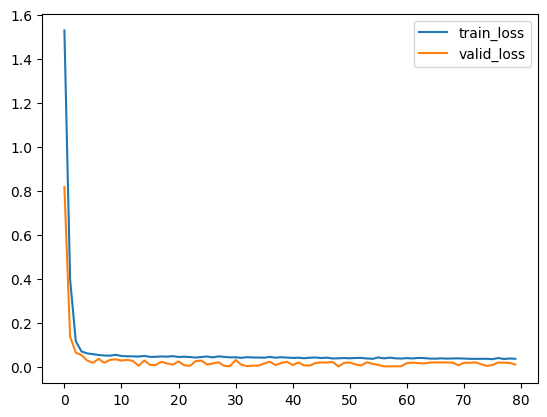

In [13]:
# train_lossとvalid_lossのプロット

plt.plot(grand_train_loss, label="train_loss")
plt.plot(grand_valid_loss, label="valid_loss")
plt.legend()
plt.show()

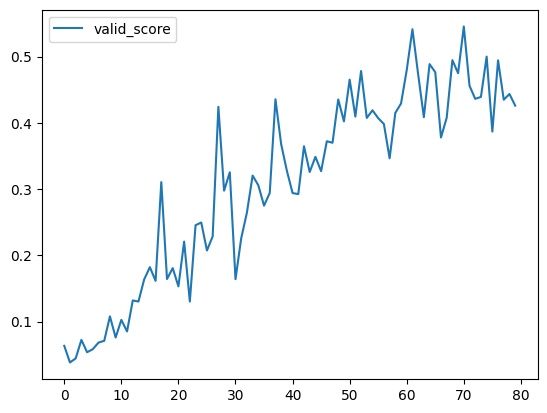

In [14]:
# train_scoreとvalid_scoreのプロット
# plt.plot(grand_train_score, label="train_score")
plt.plot(grand_valid_score, label="valid_score")
plt.legend()
plt.show()

In [15]:
random.random()

0.9910476622764169